In [1]:
import os
import sys
import pickle

import git

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

repo_path = git.Repo('.', search_parent_directories=True).working_tree_dir

if not repo_path in sys.path:
    sys.path.append(repo_path)

if not os.getcwd() == repo_path:
    os.chdir(repo_path)

In [2]:
# get relevant paths
base_path = "cluster_runs/231108/"

run_dirs = []

for p in os.listdir(base_path):
    p = base_path + p
    if os.path.isdir(p):
        print(p)
        run_dirs.append(p)

cluster_runs/231108/136054146
cluster_runs/231108/136054144
cluster_runs/231108/136054152
cluster_runs/231108/136054150
cluster_runs/231108/136054148


In [3]:
def get_pickle_paths(dir):
    if dir[-1] != "/":
        dir += "/"

    # collect pickle paths
    paths = []
    for fp in os.listdir(dir):
        if fp.endswith(".pickle"):
            print("path added: " + dir + fp)
            paths.append(dir + fp)
    return paths



freq_to_results = dict()

for p in run_dirs:
    # get paths
    pickles_paths = get_pickle_paths(p)

    with open(pickles_paths[0], "rb") as f:
        results = pickle.load(f)
        if results.system.freq == None:
            results.system.freq = 0
        freq_to_results[results.system.freq] = results
    
print(list(freq_to_results.keys()))
    

path added: cluster_runs/231108/136054146/136054146-result.pickle
path added: cluster_runs/231108/136054144/136054144-result.pickle
path added: cluster_runs/231108/136054152/136054152-result.pickle
path added: cluster_runs/231108/136054150/136054150-result.pickle
path added: cluster_runs/231108/136054148/136054148-result.pickle
[3.0, 1.0, 0, 11.0, 7.0]


In [4]:
keys = []
for key, _ in freq_to_results[1].sim_results.items():
    keys.append(key)
print(keys)

['NBM', 'CBM-Nc1', 'CBM-Nc2', 'CBM-Nc3', 'CBM-Nc4', 'CBM-Nc5', 'CBM-Nc6', 'CBM-Nc7', 'CBM-Nc8', 'CBM-Nc9', 'CBM-Nc10']


In [5]:
def delta_norm(delta_list):
    norm = 0
    for delta in delta_list:
        norm += abs(delta)**2
    
    return norm

def get_nc_from_id(id: str) -> int:
    Nc = int(id.removeprefix("CBM-Nc"))
    return Nc

In [6]:
# matplotlib.rcParams['mathtext.fontset'] = 'custom'
# matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
# matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
# matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'


Best Nc for Wl 1.0: [0.03]
Best Nc for Wl 0.333: [0.018]
Best Nc for Wl 0.143: [0.014]
Best Nc for Wl 0.091: [0.01]


/tmp/ipykernel_627815/3401742811.py:81: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()


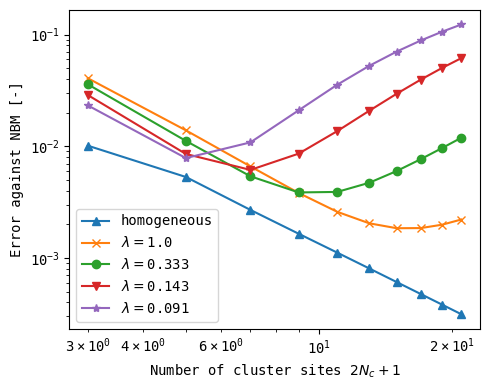

In [10]:
fig1, ax1 = plt.subplots(figsize=(5,4))

markers = ["^", "x", "o", "v", "*"]

# Constructing the data
nom_key = "NBM"


freqs = sorted(list(freq_to_results.keys()))

wl_to_errs = {}

for i, f in enumerate(freqs):
    nom_delta = freq_to_results[f].sim_results[nom_key].get_delta()

    errs = np.array([])
    cluster_sizes = np.array([])

    errs_from_clustersize = dict()

    for key in keys:
        if key == nom_key:
            continue
        
        errs_per_n = []  # err per system size
        # print(get_nc_from_id(key))

        errs_per_n.append(
            delta_norm(
                    freq_to_results[f].sim_results[key].get_delta() -\
                    nom_delta
                ) / delta_norm(nom_delta)
        )
            
        
            # print(key, err)
        errs = np.append(errs, np.mean(errs_per_n))
        cluster_sizes = np.append(cluster_sizes, get_nc_from_id(key))
        
    # label = r"f=" + str(f)

    if f == 0:
        label = "homogeneous"
    else: 
        label = r"$\lambda=$" + str(round(1/f, 3))

    ax1.plot(
        (2 * cluster_sizes + 1), 
        errs, 
        label=label,
        marker=markers[i]
    )

    if f != 0:
        wl = 1 / f
        wl_to_errs[wl] = errs

for wl, errs in wl_to_errs.items():
    print("Best Nc for Wl {0}: {1}".format(
        round(wl, 3),
        (2 * cluster_sizes[np.where(errs == min(errs))] + 1) / 500,
    ))

plt.rcParams["font.family"] = "monospace"
ax1.set_yscale('log')
ax1.set_xscale('log')
# ax1.grid()

ax1.set_xlabel(r"Number of cluster sites $2N_c + 1$")
ax1.set_ylabel("Error against NBM [-]")

size = 10
plt.xticks(fontsize=size)
plt.yticks(fontsize=size)

ax1.legend()

# ax1.set_title("Method error against cluster size for different systems")

fig1.tight_layout()
fig1.show() 

In [11]:
fig1.savefig(repo_path + "/report/figures/err_multiple_systems.eps", format="eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


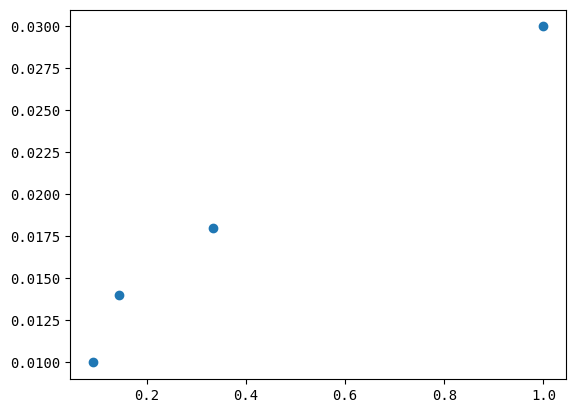

In [9]:
wls = [1, 0.333, 0.145, 0.091]
best_ncs = [0.03, 0.018, 0.014, 0.01]

plt.scatter(wls, best_ncs)

each site is 1/500 of a unit length. 

What we see is the shorter the wavelength  (autocorrelation) of the system variations are the more effective are small clusters
